In [18]:
# import
prom_api_url = "http://localhost:9090/api/v1"
metrics = prom_api_url+"/label/__name__/values"
query = prom_api_url + "/query"
query_range = prom_api_url + "/query_range"

import requests
import json
import numpy as np
import pandas as pd
import pmdarima as pm
from matplotlib import pyplot as plt
import datetime
from pmdarima import datasets
from pmdarima import utils
from pmdarima import arima
from pmdarima import model_selection
from sklearn.metrics import mean_absolute_error
from statistics import mean 
from datetime import timedelta
import os
import csv


query = os.environ.get("QUERY")
end = int(datetime.datetime.now().timestamp() - 60 * 60 * (3+3))
start = datetime.datetime.now().timestamp() - 60 * 60 * 24 * (7+3)
step = 3600
# グラフのスタイルとサイズ
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 9]

In [20]:
# query する
res = requests.get(query_range + "?query={}&start={}&end={}&step={}".format(query, start, end, step))
data = json.loads(res.content)
values = data["data"]["result"][0]["values"]
values

[[1665557301.841, '40.477480113706406'],
 [1665560901.841, '38.16783481474003'],
 [1665564501.841, '36.962767190305755'],
 [1665568101.841, '34.70274238991282'],
 [1665571701.841, '43.30751243466593'],
 [1665575301.841, '46.53187476374568'],
 [1665578901.841, '51.03773770199827'],
 [1665582501.841, '47.45964568569829'],
 [1665586101.841, '40.21237586401288'],
 [1665589701.841, '30.46190474205671'],
 [1665593301.841, '26.76398350244364'],
 [1665596901.841, '22.97276112255834'],
 [1665600501.841, '19.202899520881047'],
 [1665604101.841, '19.54522163149184'],
 [1665607701.841, '18.689270677112418'],
 [1665611301.841, '24.319435754749055'],
 [1665614901.841, '25.84106357955113'],
 [1665618501.841, '31.544538221528896'],
 [1665622101.841, '31.754442333119822'],
 [1665625701.841, '33.58461729786478'],
 [1665629301.841, '35.29999610150277'],
 [1665632901.841, '38.64525451443221'],
 [1665636501.841, '38.317475074901616'],
 [1665640101.841, '42.50568790407328'],
 [1665643701.841, '39.7879673002

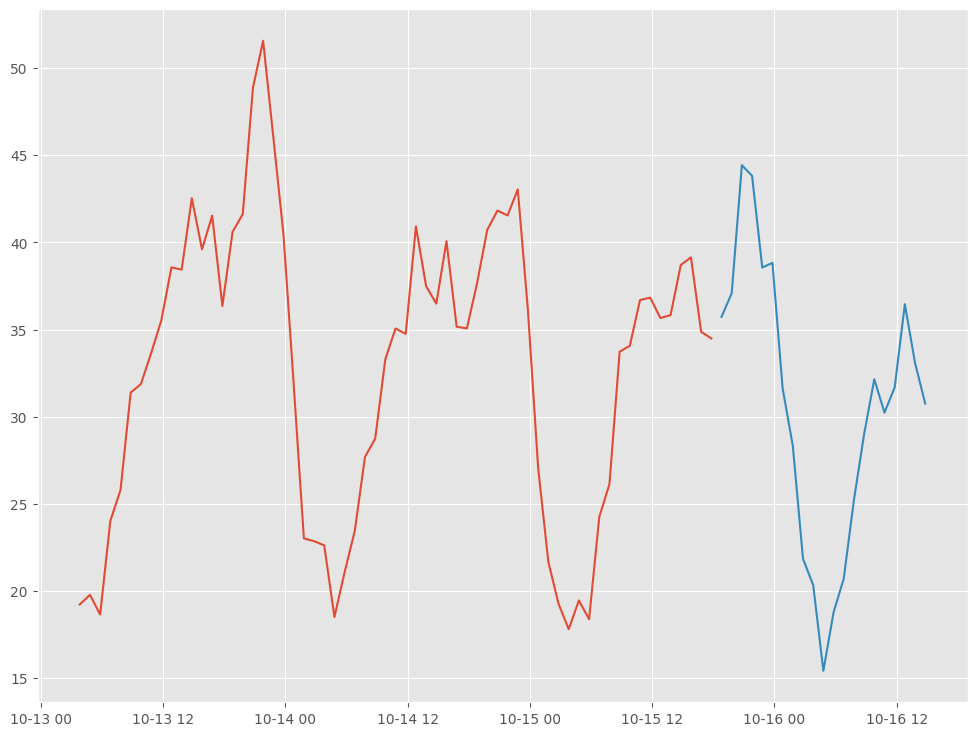

In [23]:
from pmdarima import model_selection

index = [datetime.datetime.fromtimestamp(float(v[0])) for v in values ]
raw_value = [float(v[1]) for v in values ]
s = pd.Series(raw_value, index=index)
train, test = model_selection.train_test_split(s)


plt.plot(train)
plt.plot(test)


(21,)


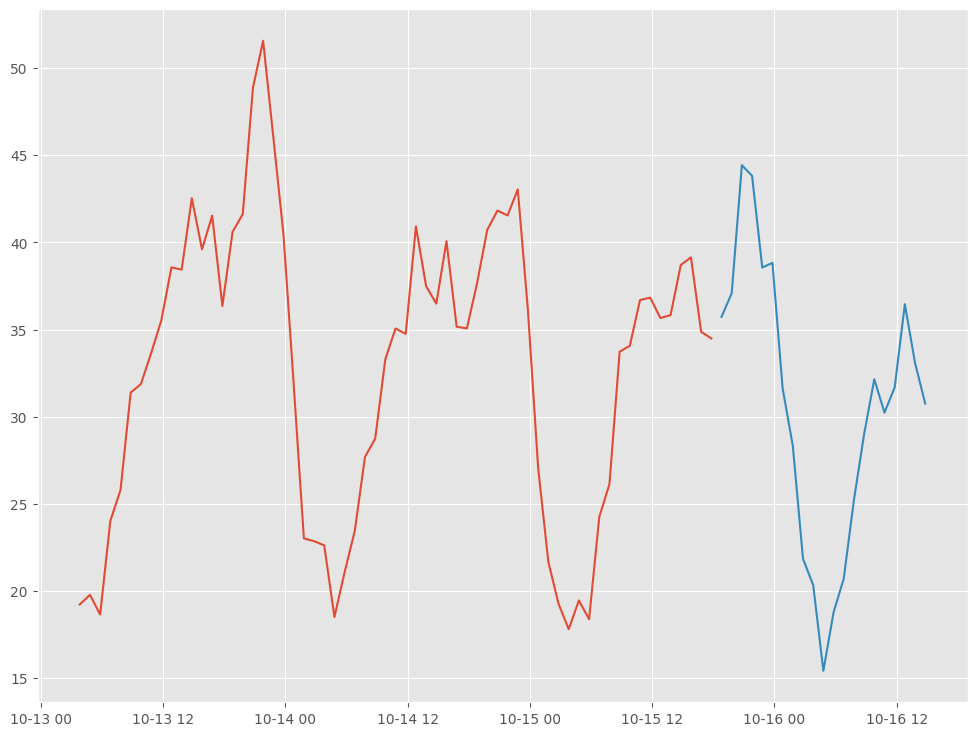

In [11]:
plt.plot(train)
plt.plot(test)
print(test.shape)

In [24]:
arima_model = pm.auto_arima(train, 
                             seasonal=True,
                             m=24,
                             d=1,
                             D=1,
                             n_jobs=-1,
                             trace=True,
                             maxiter=10)

/Users/takutaka/.go/src/github.com/takutakahashi/toybox/prom-anomaly-detection/.venv/lib/python3.10/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[24]             : AIC=197.448, Time=0.76 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=214.426, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=191.483, Time=0.33 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=inf, Time=0.35 sec
 ARIMA(1,1,0)(0,1,0)[24]             : AIC=200.441, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[24]             : AIC=193.483, Time=4.70 sec
 ARIMA(1,1,0)(1,1,1)[24]             : AIC=193.484, Time=0.40 sec
 ARIMA(1,1,0)(0,1,1)[24]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,0)(2,1,1)[24]             : AIC=195.483, Time=5.77 sec
 ARIMA(0,1,0)(1,1,0)[24]             : AIC=203.000, Time=0.12 sec
 ARIMA(2,1,0)(1,1,0)[24]             : AIC=191.706, Time=0.37 sec
 ARIMA(1,1,1)(1,1,0)[24]             : AIC=191.484, Time=0.39 sec
 ARIMA(0,1,1)(1,1,0)[24]             : AIC=190.357, Time=0.28 sec
 ARIMA(0,1,1)(0,1,0)[24]             : AIC=196.951, Time=0.02 sec
 ARIMA(0,1,1)(2,1,0)[24]             : AI

MAE:
2.0895591855775577
MAPE(%):
6.999290659711768


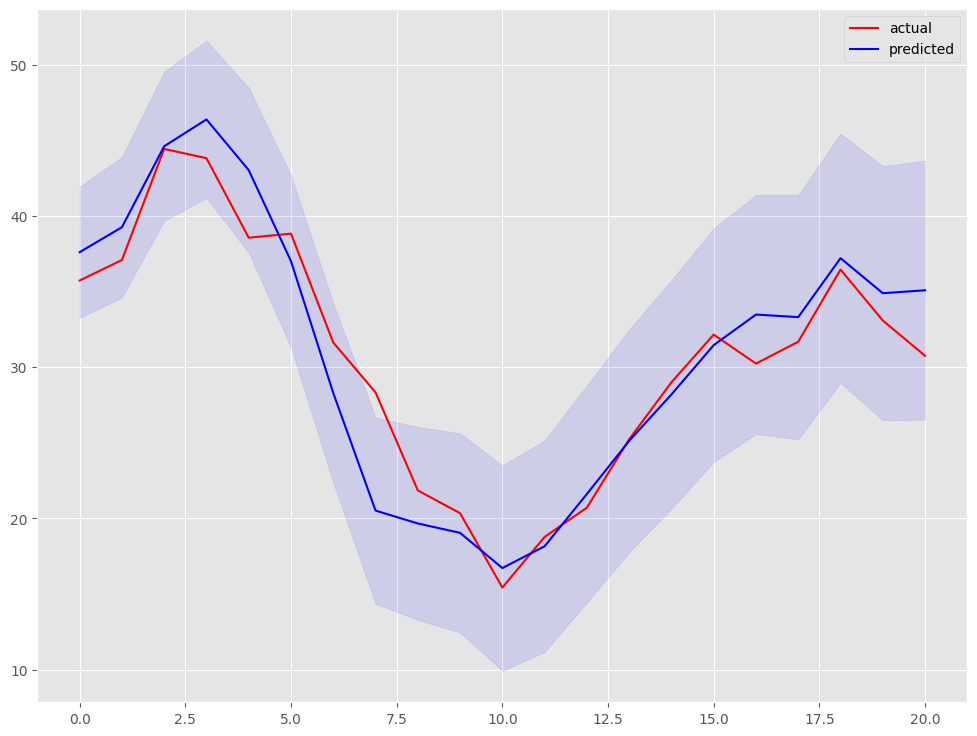

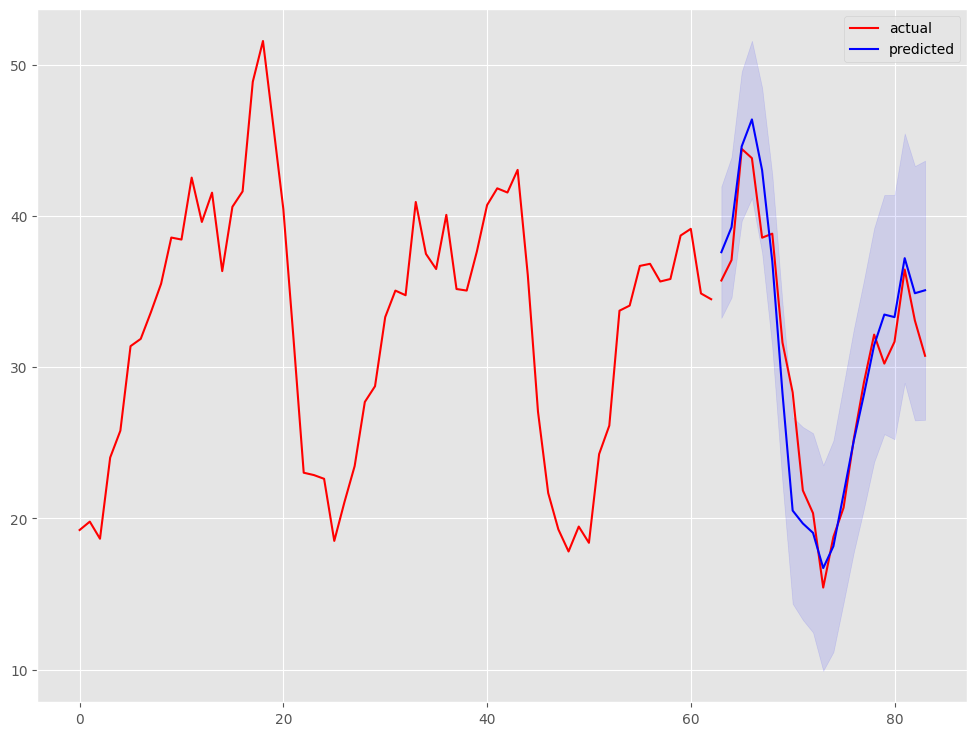

In [25]:

# 予測
preds, conf_int = arima_model.predict(n_periods=test.shape[0], 
                                      return_conf_int=True)


# code refs: https://www.salesanalytics.co.jp/datascience/datascience064/

# 予測精度
print('MAE:')
print(mean_absolute_error(test, preds)) 
print('MAPE(%):')
print(mean(abs(test - preds)/test) *100)
# 予測と実測の比較（グラフ）
x_axis = np.arange(preds.shape[0])
plt.plot(x_axis,test,label="actual",color='r') 
plt.plot(x_axis,preds,label="predicted",color='b')
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b')
plt.legend()
plt.show()
# グラフ（学習データとテストデータ、予測結果）
x_axis = np.arange(train.shape[0] + preds.shape[0])
plt.plot(x_axis[:train.shape[0]],train,color='r',label="actual")
plt.plot(x_axis[train.shape[0]:],test,color='r')
plt.plot(x_axis[train.shape[0]:],preds,color='b',label="predicted")
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1,color='b')
plt.legend()
plt.show()

In [16]:
print(test[0])
print(test.shape[0])
print(preds)

35.72621255365726
21
2022-10-15 18:48:24.906    37.598331
2022-10-15 19:48:24.906    39.249840
2022-10-15 20:48:24.906    44.602011
2022-10-15 21:48:24.906    46.378408
2022-10-15 22:48:24.906    43.024553
2022-10-15 23:48:24.906    37.004640
2022-10-16 00:48:24.906    28.287352
2022-10-16 01:48:24.906    20.513433
2022-10-16 02:48:24.906    19.661729
2022-10-16 03:48:24.906    19.039420
2022-10-16 04:48:24.906    16.712481
2022-10-16 05:48:24.906    18.154232
2022-10-16 06:48:24.906    21.611641
2022-10-16 07:48:24.906    25.123426
2022-10-16 08:48:24.906    28.192161
2022-10-16 09:48:24.906    31.452681
2022-10-16 10:48:24.906    33.475196
2022-10-16 11:48:24.906    33.305932
2022-10-16 12:48:24.906    37.204125
2022-10-16 13:48:24.906    34.885588
2022-10-16 14:48:24.906    35.081652
Freq: H, dtype: float64
